## Seq2seq models and attention

This time we'll solve a problem of transribing hebrew words in english, also known as g2p (grapheme2phoneme)

 * word (sequence of letters in source language) -> translation (sequence of letters in target language)


### About the task

One notable property of Hebrew is that it's consonant language. That is, there are no wovels in the written language. One could represent wovels with diacritics above consonants, but you don't expect people to do that in everyay life.

Therefore, some hebrew characters will correspond to several english letters and others - to none, so we should use encoder-decoder architecture to figure that out.

![img](https://esciencegroup.files.wordpress.com/2016/03/seq2seq.jpg)
_(img: esciencegroup.files.wordpress.com)_

Encoder-decoder architectures are about converting anything to anything, including
 * Machine translation and spoken dialogue systems
 * [Image captioning](http://mscoco.org/dataset/#captions-challenge2015) and [image2latex](https://openai.com/requests-for-research/#im2latex) (convolutional encoder, recurrent decoder)
 * Generating [images by captions](https://arxiv.org/abs/1511.02793) (recurrent encoder, convolutional decoder)
 * Grapheme2phoneme - convert words to transcripts
  
We chose simplified __Hebrew->English__ machine translation for words and short phrases (character-level), as it is relatively quick to train even without a gpu cluster.

In [1]:
EASY_MODE = True        #If True, only translates phrases shorter than 20 characters (way easier).
                        #Useful for initial coding.
                        #If false, works with all phrases (please switch to this mode for homework assignment)

MODE = "he-to-en"                                #way we translate. Either "he-to-en" or "en-to-he"
MAX_OUTPUT_LENGTH = 50 if not EASY_MODE else 20  #maximal length of _generated_ output, does not affect training
REPORT_FREQ       = 100                          #how often to evaluate validation score

### Step 1: preprocessing

We shall store dataset as a dictionary
`{ word1:[translation1,translation2,...], word2:[...],...}`.

This is mostly due to the fact that many words have several correct translations.

We have implemented this thing for you so that you can focus on more interesting parts.


__Attention python2 users!__ You may want to cast everything to unicode later during homework phase, just make sure you do it _everywhere_.

In [2]:
import numpy as np
from collections import defaultdict
word_to_translation = defaultdict(list) #our dictionary

bos = '_'
eos = ';'

with open("main_dataset.txt") as fin:
    for line in fin:
        
        en,he = line[:-1].lower().replace(bos,' ').replace(eos,' ').split('\t')
        word,trans = (he,en) if MODE=='he-to-en' else (en,he)
        
        if len(word) < 3: continue
        if EASY_MODE:
            if max(len(word),len(trans))>20:
                continue
        
        word_to_translation[word].append(trans)
    
print ("size = ",len(word_to_translation))

size =  130113


In [4]:
#get all unique lines in source language
all_words = np.array(list(word_to_translation.keys()))
# get all unique lines in translation language
all_translations = np.array([ts for all_ts in word_to_translation.values() for ts in all_ts])


### split the dataset

We hold out 10% of all words to be used for validation.


In [5]:
from sklearn.model_selection import train_test_split
train_words,test_words = train_test_split(all_words,test_size=0.1,random_state=42)

### Building vocabularies

We now need to build vocabularies that map strings to token ids and vice versa. We're gonna need these fellas when we feed training data into model or convert output matrices into english words.

In [6]:
from voc import Vocab
inp_voc = Vocab.from_lines(''.join(all_words), bos=bos, eos=eos, sep='')
out_voc = Vocab.from_lines(''.join(all_translations), bos=bos, eos=eos, sep='')

In [7]:
# Here's how you cast lines into ids and backwards.
batch_lines = all_words[:5]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['אנרכיזם' 'אוטיזם קלאסי' 'אלבדו' 'אלבמה' 'אכילס']

words to ids (0 = bos, 1 = eos):
[[  0  88 129 100 106  56 103 108   1   1   1   1   1   1]
 [  0  88  81 146  56 103 108 137 121 184  88 155  56   1]
 [  0  88 184  40 123  81   1   1   1   1   1   1   1   1]
 [  0  88 184  40 157 128   1   1   1   1   1   1   1   1]
 [  0  88 106  56 184 155   1   1   1   1   1   1   1   1]]

back to words
['אנרכיזם', 'אוטיזם קלאסי', 'אלבדו', 'אלבמה', 'אכילס']


Draw word/translation length distributions to estimate the scope of the task.

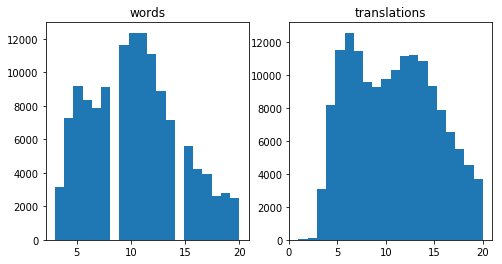

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=[8,4])
plt.subplot(1,2,1)
plt.title("words")
plt.hist(list(map(len,all_words)),bins=20);

plt.subplot(1,2,2)
plt.title('translations')
plt.hist(list(map(len,all_translations)),bins=20);


### Step 2: deploy encoder-decoder (2 points)

__assignment starts here__

Our architecture consists of two main blocks:
* Encoder reads words character by character and outputs code vector (usually a function of last RNN state)
* Decoder takes that code vector and produces translations character by character

Than it gets fed into a model that follows this simple interface:
* __`model.symbolic_translate(inp, **flags) -> out, logp`__ - takes symbolic int32 matrix of hebrew words, produces output tokens sampled from the model and output log-probabilities for all possible tokens at each tick.
* __`model.symbolic_score(inp, out, **flags) -> logp`__ - takes symbolic int32 matrices of hebrew words and their english translations. Computes the log-probabilities of all possible english characters given english prefices and hebrew word.
* __`model.weights`__ - weights from all model layers [a list of variables]

That's all! It's as hard as it gets. With those two methods alone you can implement all kinds of prediction and training.

In [9]:
import tensorflow as tf
tf.reset_default_graph()
s = tf.InteractiveSession()

# ^^^ if you get "variable *** already exists": re-run this cell again

In [10]:
from basic_model import BasicTranslationModel
model = BasicTranslationModel('model',inp_voc,out_voc,
                              emb_size=32, hid_size=64)

# PLEASE DON'T CHANGE THESE VALUES: emb_size=32, hid_size=64

s.run(tf.global_variables_initializer())

Using TensorFlow backend.


In [11]:
# Play around with symbolic_translate and symbolic_score
inp = tf.placeholder_with_default(np.random.randint(0,10,[3,5],dtype='int32'),[None,None])
out = tf.placeholder_with_default(np.random.randint(0,10,[3,5],dtype='int32'),[None,None])

# translate inp (with untrained model)
sampled_out, logp = out,model.symbolic_translate(inp, greedy=False)
print("\nSymbolic_translate output:\n",out,logp)
print("\nSample translations:\n", s.run(sampled_out))


Symbolic_translate output:
 Tensor("PlaceholderWithDefault_1:0", shape=(?, ?), dtype=int32) (<tf.Tensor 'transpose_2:0' shape=(?, ?) dtype=int32>, <tf.Tensor 'Reshape_1:0' shape=(?, ?, 283) dtype=float32>)

Sample translations:
 [[3 7 1 9 0]
 [1 3 3 1 8]
 [1 2 0 0 9]]


In [12]:
# score logp(out | inp) with untrained input
logp = model.symbolic_score(inp,out)
print("\nSymbolic_score output:\n",logp)
print("\nLog-probabilities (clipped):\n", s.run(logp)[:,:2,:5])


Symbolic_score output:
 Tensor("Reshape_3:0", shape=(?, ?, 283), dtype=float32)

Log-probabilities (clipped):
 [[[  0.         -69.0775528  -69.0775528  -69.0775528  -69.0775528 ]
  [ -5.63236141  -5.62887812  -5.64145279  -5.65161991  -5.64647388]]

 [[  0.         -69.0775528  -69.0775528  -69.0775528  -69.0775528 ]
  [ -5.63965464  -5.63373947  -5.63873529  -5.63782215  -5.63872576]]

 [[  0.         -69.0775528  -69.0775528  -69.0775528  -69.0775528 ]
  [ -5.64781857  -5.6305728   -5.66333914  -5.62514734  -5.63871861]]]


In [13]:
# Prepare any operations you want here
input_sequence = tf.placeholder('int32', [None,None])
greedy_translations, logp = model.symbolic_translate(input_sequence, greedy=True)
    
def translate(lines):
    """
    You are given a list of input lines. 
    Make your neural network translate them.
    :return: a list of output lines
    """
    # Convert lines to a matrix of indices
    lines_ix = inp_voc.to_matrix(lines)

    # Compute translations in form of indices
    trans_ix = s.run(greedy_translations, {input_sequence: lines_ix})

    # Convert translations back into strings
    return out_voc.to_lines(trans_ix)

In [14]:
print("Sample inputs:",all_words[:3])
print("Dummy translations:",translate(all_words[:3]))

assert isinstance(greedy_translations,tf.Tensor) and greedy_translations.dtype.is_integer, "trans must be a tensor of integers (token ids)"
assert translate(all_words[:3]) == translate(all_words[:3]), "make sure translation is deterministic (use greedy=True and disable any noise layers)"
assert type(translate(all_words[:3])) is list and (type(translate(all_words[:1])[0]) is str or type(translate(all_words[:1])[0]) is unicode), "translate(lines) must return a sequence of strings!"
print("Tests passed!")

Sample inputs: ['אנרכיזם' 'אוטיזם קלאסי' 'אלבדו']
Dummy translations: ['ëälоטکđŏ-•ז3•õy•eť•ז′一lהŭťעľ', 'ùקfעľı–iʻœģñŭỏóז″ùúųģâķ‘ỹы_ù', '子äאŭťğ̇ýŋiyğșש′•קiеi(,ן’õșėρ']
Tests passed!


### Scoring function

LogLikelihood is a poor estimator of model performance.
* If we predict zero probability once, it shouldn't ruin entire model.
* It is enough to learn just one translation if there are several correct ones.
* What matters is how many mistakes model's gonna make when it translates!

Therefore, we will use minimal Levenshtein distance. It measures how many characters do we need to add/remove/replace from model translation to make it perfect. Alternatively, one could use character-level BLEU/RougeL or other similar metrics.

The catch here is that Levenshtein distance is not differentiable: it isn't even continuous. We can't train our neural network to maximize it by gradient descent.

In [15]:
!pip install editdistance

In [16]:
import editdistance # !pip install editdistance

def get_distance(word,trans):
    """
    A function that takes word and predicted translation
    and evaluates (Levenshtein's) edit distance to closest correct translation
    """
    references = word_to_translation[word]
    assert len(references)!=0,"wrong/unknown word"
    return min(editdistance.eval(trans,ref) for ref in references)

def score(words, bsize=100):
    """a function that computes levenshtein distance for bsize random samples"""
    assert isinstance(words,np.ndarray)
    
    batch_words = np.random.choice(words,size=bsize,replace=False)
    batch_trans = translate(batch_words)
    
    distances = list(map(get_distance,batch_words,batch_trans))
    
    return np.array(distances,dtype='float32')

In [17]:
#should be around 5-50 and decrease rapidly after training :)
[score(test_words,10).mean() for _ in range(5)]

[41.099998, 33.400002, 32.799999, 33.299999, 29.700001]

## Step 3: Training (2 points)

Here we define a function that trains our model through maximizing log-likelihood a.k.a. minimizing crossentropy.

In [18]:
# import utility functions
from basic_model import initialize_uninitialized, infer_length, infer_mask, select_values_over_last_axis

class supervised_training:

    # variable for inputs and correct answers
    input_sequence = tf.placeholder('int32',[None,None])
    reference_answers = tf.placeholder('int32',[None,None])
    
    # Compute log-probabilities of all possible tokens at each step. Use model interface.
    logprobs_seq = model.symbolic_score(input_sequence, reference_answers)
    
    # compute mean crossentropy
    crossentropy = - select_values_over_last_axis(logprobs_seq,reference_answers)
    
    mask = infer_mask(reference_answers, out_voc.eos_ix)
    
    loss = tf.reduce_sum(crossentropy * mask)/tf.reduce_sum(mask)
    
    # Build weights optimizer. Use model.weights to get all trainable params.
    opt = tf.train.AdamOptimizer()
    updates = opt.compute_gradients(loss, model.weights)
    optimizer = opt.apply_gradients(updates)
    train_step = optimizer
    
    
# intialize optimizer params while keeping model intact
initialize_uninitialized(s)

Actually run training on minibatches

In [19]:
import random
def sample_batch(words, word_to_translation, batch_size):
    """
    sample random batch of words and random correct translation for each word
    example usage:
    batch_x,batch_y = sample_batch(train_words, word_to_translations,10)
    """
    #choose words
    batch_words = np.random.choice(words,size=batch_size)
    
    #choose translations
    batch_trans_candidates = list(map(word_to_translation.get,batch_words))
    batch_trans = list(map(random.choice,batch_trans_candidates))
    
    return inp_voc.to_matrix(batch_words), out_voc.to_matrix(batch_trans)

In [20]:
bx,by = sample_batch(train_words, word_to_translation, batch_size=3)
print("Source:")
print(bx)
print("Target:")
print(by)

Source:
[[  0 121 146  65  81 100  56 128 118 157  37 103  81  12 137  20 188  21
  116   1]
 [  0 100  81 103 137 121 129 123  56   1   1   1   1   1   1   1   1   1
    1   1]
 [  0  37  65  81 100  12 137 121  81  56 162 100   1   1   1   1   1   1
    1   1]]
Target:
[[  0  27 282  30 178 207 240 221 213  46  58   1   1   1]
 [  0   5 129  58  10 207 275  10  11  11  10  35  46   1]
 [  0 275 210 227 240  10   5 207 208  10 221  29   1   1]]


In [21]:
!pip install tqdm

In [31]:
from IPython.display import clear_output
from tqdm import tqdm,trange #or use tqdm_notebook,tnrange

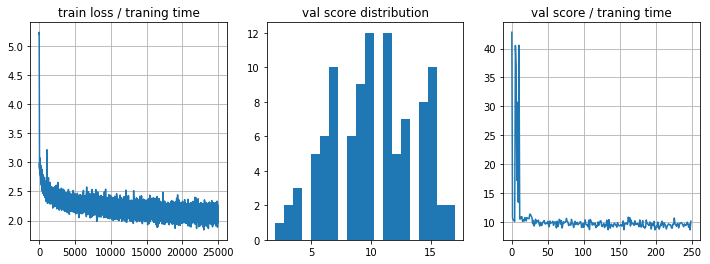

100%|██████████| 25000/25000 [09:30<00:00, 43.81it/s]

llh=2.121, mean score=9.497


In [24]:


loss_history=[]
editdist_history = []

for i in trange(25000):
    bx,by = sample_batch(train_words, word_to_translation, 32)
    
    feed_dict = {
        supervised_training.input_sequence:bx,
        supervised_training.reference_answers:by
    }
    
    loss,_ = s.run([supervised_training.loss,supervised_training.train_step],feed_dict)
    loss_history.append(loss)
    
    if (i+1)%REPORT_FREQ==0:
        clear_output(True)
        current_scores = score(test_words)
        editdist_history.append(current_scores.mean())
        plt.figure(figsize=(12,4))
        plt.subplot(131)
        plt.title('train loss / traning time')
        plt.plot(loss_history)
        plt.grid()
        plt.subplot(132)
        plt.title('val score distribution')
        plt.hist(current_scores, bins = 20)
        plt.subplot(133)
        plt.title('val score / traning time')
        plt.plot(editdist_history)
        plt.grid()
        plt.show()
        print("llh=%.3f, mean score=%.3f"%(np.mean(loss_history[-10:]),np.mean(editdist_history[-10:])))
        
# Note: it's okay if loss oscillates up and down as long as it gets better on average over long term (e.g. 5k batches)

In [22]:
for word in train_words[:10]:
    print("%s -> %s"%(word,translate([word])[0]))

כל אנשי סמיילי -> =,‘ʿηyòỏק9æľןь門ùõș•ěỏ(⋯وτıżtwזỏδ
קטגוריה:ערוץ 2 -> úəcлהóזسеvņ(,rň1şăվ≤σチņcŭứ一iسηòż
עבודה מהבית -> 子яľă·ứטôbکq·とőζцʻ″īïτ子コô•a
פראליה -> gمlоטکلцדớ⋯q•זε猫
קפלר 42 -> ùʿdぼzя守野ķğ(ïq•ぺứ•ẓ
קטגוריה:מתאסלמים -> gälùטρ″یzטとկ3ůěτ″œcש♭oеהņфæ野ńыôßцťい⋯
בושמי -> ùק'о″ábảվõ″ųղと
לאונרדו -> 子якā$•úē•+ʻ•еε猫קấצ
שאמה -> gcťоõôáķф(eb
עכברה -> ľäạоשá$þ-ešτ…œ


In [26]:
test_scores = []
for start_i in trange(0,len(test_words),32):
    batch_words = test_words[start_i:start_i+32]
    batch_trans = translate(batch_words)
    distances = list(map(get_distance,batch_words,batch_trans))
    test_scores.extend(distances)
    
print("Supervised test score:", np.mean(test_scores))

100%|██████████| 407/407 [00:05<00:00, 75.03it/s]

Supervised test score: 9.48655087611


## Step 4: Make it actually work (up to 26 points)

In this section we want you to experiment to find a good model for the task.

**What would be good**:

1) try different recurrent units

2) implement attention - compulsory!

3) try bidirectional rnn/gru/lstm

4) try different functions for attention

5) any other ideas are welcome!

**Requirements**:

1) less than 1.2 llh

2) less than 6 points test score

3) don't change emb_size=32, hid_size=64 (if you're using bidirectional rnn, hid size for each must be 32 to get overall hid_size=64)

**What we expect to get**:

1) results with models in this notebook (top-n models)

2) a brief report describing your experiments and results: what have you tried, why, etc.

**What files you need to send**:

1) this notebook

2) file .py similar to ours basic_model.py with all your models and attentions


Below is the version of attention template: you can use it if you want.

Let's make one joined function to run and evaluate models.

In [23]:
def run_eval(words, training, bsize=100):
    # Prepare any operations you want here
    def translate(lines, training):
        """
        You are given a list of input lines. 
        Make your neural network translate them.
        :return: a list of output lines
        """
        # Convert lines to a matrix of indices
        lines_ix = inp_voc.to_matrix(lines)

        # Compute translations in form of indices
        trans_ix = s.run(training.greedy_translations, {training.input_sequence: lines_ix})

        # Convert translations back into strings
        return out_voc.to_lines(trans_ix)
    
    def score(words, training, bsize=100):
        """a function that computes levenshtein distance for bsize random samples"""
        assert isinstance(words,np.ndarray)

        batch_words = np.random.choice(words,size=bsize,replace=False)
        batch_trans = translate(batch_words, training)

        distances = list(map(get_distance,batch_words,batch_trans))

        return np.array(distances,dtype='float32')
    return score(words, training, bsize)
    

In [28]:
def run_model(model, n_steps=25000, lr=1e-3):
    class supervised_training:
        # variable for inputs and correct answers
        input_sequence = tf.placeholder('int32',[None,None])
        reference_answers = tf.placeholder('int32',[None,None])

        greedy_translations, _ = model.symbolic_translate(input_sequence, greedy=True)

        # Compute log-probabilities of all possible tokens at each step. Use model interface.
        logprobs_seq = model.symbolic_score(input_sequence, reference_answers)

        # compute mean crossentropy
        crossentropy = - select_values_over_last_axis(logprobs_seq,reference_answers)

        mask = infer_mask(reference_answers, out_voc.eos_ix)

        loss = tf.reduce_sum(crossentropy * mask)/tf.reduce_sum(mask)

        # Build weights optimizer. Use model.weights to get all trainable params.
        opt = tf.train.AdamOptimizer(1e-3)
        updates = opt.compute_gradients(loss, model.weights)
        optimizer = opt.apply_gradients(updates)
        train_step = optimizer
    
    def translate(lines):
        """
        You are given a list of input lines. 
        Make your neural network translate them.
        :return: a list of output lines
        """
        # Convert lines to a matrix of indices
        lines_ix = inp_voc.to_matrix(lines)

        # Compute translations in form of indices
        trans_ix = s.run(supervised_training.greedy_translations, 
                         {supervised_training.input_sequence: lines_ix})

        # Convert translations back into strings
        return out_voc.to_lines(trans_ix)
    
    
    # intialize optimizer params while keeping model intact
    initialize_uninitialized(s)
    
    loss_history=[]
    editdist_history = []

    try:
        for i in trange(n_steps):
            bx,by = sample_batch(train_words, word_to_translation, 32)

            feed_dict = {
                supervised_training.input_sequence:bx,
                supervised_training.reference_answers:by
            }

            loss,_ = s.run([supervised_training.loss,supervised_training.train_step],feed_dict)
            loss_history.append(loss)

            if (i+1)%REPORT_FREQ==0:
                clear_output(True)
                current_scores = run_eval(test_words, supervised_training)
                editdist_history.append(current_scores.mean())
                plt.figure(figsize=(12,4))
                plt.subplot(131)
                plt.title('train loss / traning time')
                plt.plot(loss_history)
                plt.grid()
                plt.subplot(132)
                plt.title('val score distribution')
                plt.hist(current_scores, bins = 20)
                plt.subplot(133)
                plt.title('val score / traning time')
                plt.plot(editdist_history)
                plt.grid()
                plt.show()
                print("llh=%.3f, mean score=%.3f"%(np.mean(loss_history[-10:]),np.mean(editdist_history[-10:])))
    except KeyboardInterrupt:
        print ('KeyboardInterrupted - enought learning')
        
    for word in train_words[:10]:
        print("%s -> %s"%(word,translate([word])[0]))
    
    test_scores = []
    for start_i in trange(0,len(test_words),32):
        batch_words = test_words[start_i:start_i+32]
        batch_trans = translate(batch_words)
        distances = list(map(get_distance,batch_words,batch_trans))
        test_scores.extend(distances)

    print("Supervised test score:", np.mean(test_scores))

In [29]:
%load_ext autoreload
%autoreload 2

In [24]:
import imp

Let's try to use GRU cell instead of RNN cell.

In [25]:
# import imp
# imp.reload(GRU_model)
from GRU_model import GRUTranslationModel
tf.reset_default_graph()
s = tf.InteractiveSession()

model = GRUTranslationModel('gru_model', inp_voc, out_voc,
                              emb_size=32, hid_size=64)

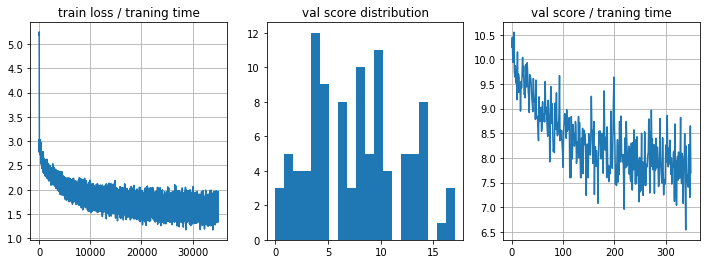

  1%|▏         | 6/407 [00:00<00:07, 55.48it/s]

llh=1.600, mean score=7.799
כל אנשי סמיילי -> salis in manical sand
קטגוריה:ערוץ 2 -> art 2
עבודה מהבית -> althot of harom
פראליה -> paralia
קפלר 42 -> caler 42
קטגוריה:מתאסלמים -> mastomalism
בושמי -> bomish
לאונרדו -> laundro
שאמה -> shama
עכברה -> achaba


100%|██████████| 407/407 [00:07<00:00, 53.89it/s]

Supervised test score: 7.82508453735


In [32]:
run_model(model, 35000)

Not enough :(

Let's try to change GRU to LSTM cell

In [26]:
# imp.reload(LSTM_model)
from LSTM_model import LSTMTranslationModel
tf.reset_default_graph()
s = tf.InteractiveSession()

model = LSTMTranslationModel('lstm_model', inp_voc, out_voc,
                              emb_size=32, hid_size=64)

This time LSTM is a bit better in llh but worse in mean score, but previous runs GRU was much better than LSTM. Also GRU is a bit simplier, so let's try bidirectional GRU.

In [ ]:
# import imp
# imp.reload(GRU_model)
from GRU_model import GRUTranslationModel
tf.reset_default_graph()
s = tf.InteractiveSession()

model = GRUTranslationModel('gru_model_bid', inp_voc, out_voc,
                              emb_size=32, hid_size=64, bidirectional=True)

In [ ]:
run_model(model, 30000)

  0%|          | 9/30000 [00:00<24:22, 20.51it/s]  

Still not enough. Next attemp is Attention based on GRU (first run - bidirectional, second - only forward). As sentences are not very long and we don't have a lot of train data to train all LSTM params, it seems that it should work with GRU.

In [29]:
from Attention_model import AttentionGRUTranslationModel
tf.reset_default_graph()
s = tf.InteractiveSession()

model = AttentionGRUTranslationModel('attention_bidir_gru', inp_voc, out_voc,
                              emb_size=32, hid_size=64, bidirectional=True)

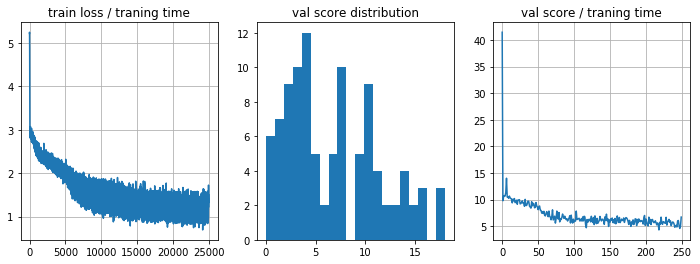

  0%|          | 2/407 [00:00<00:27, 14.99it/s]

llh=1.433, mean score=5.328
כל אנשי סמיילי -> kamili camili
קטגוריה:ערוץ 2 -> aso propp
עבודה מהבית -> aboda mahib
פראליה -> pralia
קפלר 42 -> kepel 12
קטגוריה:מתאסלמים -> mathellism
בושמי -> bossim
לאונרדו -> leonerdo
שאמה -> shama
עכברה -> achebara


100%|██████████| 407/407 [00:30<00:00, 13.48it/s]

Supervised test score: 6.06801414079


In [32]:
run_model(model)

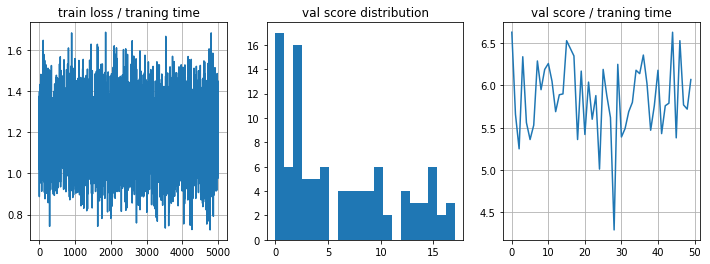

  0%|          | 0/407 [00:00<?, ?it/s]

llh=1.232, mean score=5.926
כל אנשי סמיילי -> call anshi samili
קטגוריה:ערוץ 2 -> astring of chine
עבודה מהבית -> aboda mahavit
פראליה -> pralia
קפלר 42 -> batter the lach
קטגוריה:מתאסלמים -> mathaslamim
בושמי -> boshmi
לאונרדו -> launardo
שאמה -> shama
עכברה -> achabra


100%|██████████| 407/407 [01:08<00:00,  5.90it/s]

Supervised test score: 5.84867814325


In [34]:
run_model(model, 5000)

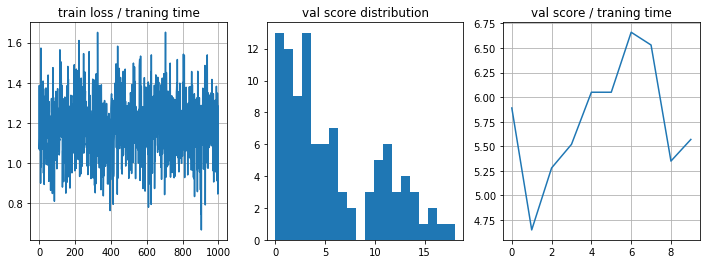

100%|██████████| 1000/1000 [05:15<00:00,  3.17it/s]

llh=1.134, mean score=5.755
כל אנשי סמיילי -> cal anshi smilli
קטגוריה:ערוץ 2 -> cattle sease
עבודה מהבית -> aboda mahavit
פראליה -> pralia
קפלר 42 -> battle bat



  0%|          | 1/407 [00:00<00:57,  7.01it/s]

קטגוריה:מתאסלמים -> matasalmim
בושמי -> boshami
לאונרדו -> leonerdo
שאמה -> shama
עכברה -> achabra


100%|██████████| 407/407 [01:14<00:00,  5.44it/s]

Supervised test score: 5.81839840148


In [35]:
run_model(model, 1000, 1e-4)

Because of oscilating (see it on the plots) have to catch good score. Finally caught it.

# Deal with it!

Let's make some more experiments. At first run only forward GRU.

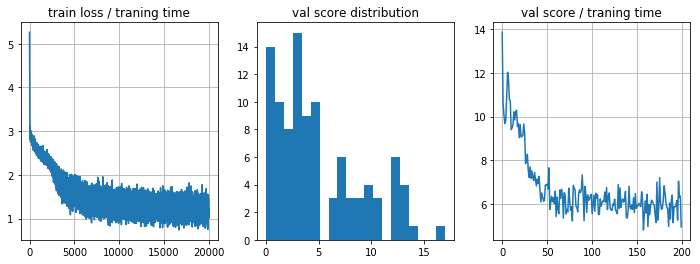

  0%|          | 0/407 [00:00<?, ?it/s]

llh=1.165, mean score=5.893
כל אנשי סמיילי -> ansie samili
קטגוריה:ערוץ 2 -> cant of 2
עבודה מהבית -> aboda mahavith
פראליה -> pralia
קפלר 42 -> kapler 42
קטגוריה:מתאסלמים -> mathaslamim
בושמי -> boshmi
לאונרדו -> launerdo
שאמה -> shama
עכברה -> achavera


100%|██████████| 407/407 [00:39<00:00, 10.43it/s]

Supervised test score: 5.95127574547


In [98]:
from Attention_model import AttentionGRUTranslationModel
tf.reset_default_graph()
s = tf.InteractiveSession()

model = AttentionGRUTranslationModel('attention_dir_gru', inp_voc, out_voc,
                              emb_size=32, hid_size=64, bidirectional=False)
run_model(model, 20000)

Try random initialization

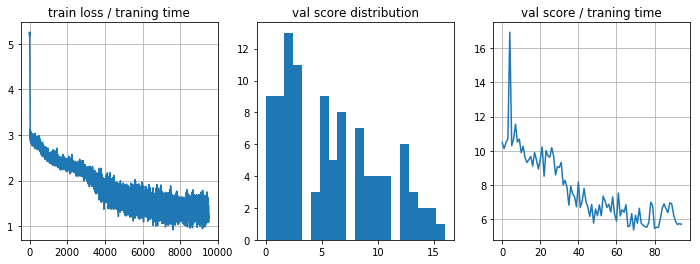

 38%|███▊      | 9500/25000 [31:13<50:56,  5.07it/s]

llh=1.288, mean score=6.318


  0%|          | 0/407 [00:00<?, ?it/s]

KeyboardInterrupted - enought learning
כל אנשי סמיילי -> anshi samili
קטגוריה:ערוץ 2 -> arot 2
עבודה מהבית -> aboda mahith
פראליה -> pralia
קפלר 42 -> kapler 42
קטגוריה:מתאסלמים -> mathasselmis
בושמי -> boshami
לאונרדו -> launerdo
שאמה -> shama
עכברה -> achavera



 15%|█▌        | 63/407 [00:08<00:46,  7.35it/s]
Exception in thread Thread-18:
Traceback (most recent call last):
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/boyalex/shad/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/boyalex/shad/bin/../lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 407/407 [00:48<00:00,  8.47it/s]

Supervised test score: 6.16922840455


In [36]:
from Attention_model import AttentionGRUTranslationModel
tf.reset_default_graph()
s = tf.InteractiveSession()

model = AttentionGRUTranslationModel('attention_dir_gru', inp_voc, out_voc,
                              emb_size=32, hid_size=64, bidirectional=False, init='random')
run_model(model)

Picture seems to be the same

Finally, let's try to change attention function to tanh

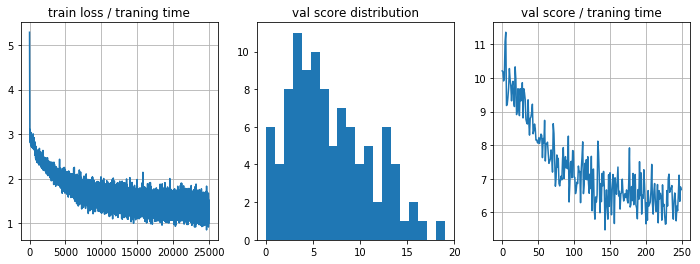

  0%|          | 0/407 [00:00<?, ?it/s]

llh=1.306, mean score=6.434
כל אנשי סמיילי -> calles marisines
קטגוריה:ערוץ 2 -> artun stre
עבודה מהבית -> avim mahabit
פראליה -> pralia
קפלר 42 -> capler 42
קטגוריה:מתאסלמים -> matselms
בושמי -> boshmis
לאונרדו -> laundrod
שאמה -> shama
עכברה -> abbara


100%|██████████| 407/407 [00:37<00:00, 10.87it/s]

Supervised test score: 6.39863203197


In [47]:
from Attention_model import AttentionGRUTranslationModel
tf.reset_default_graph()
s = tf.InteractiveSession()

model = AttentionGRUTranslationModel('attention_bidir_gru', inp_voc, out_voc,
                              emb_size=32, hid_size=64, bidirectional=True, attention_fun='tanh', init='random')
run_model(model)

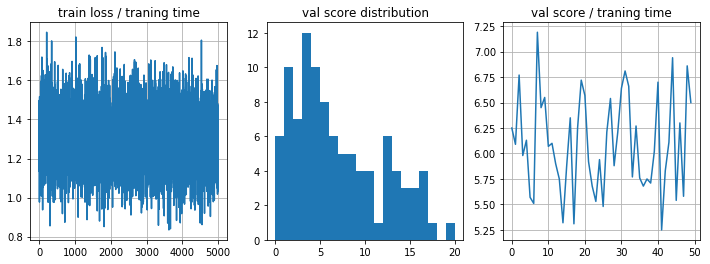

  0%|          | 0/407 [00:00<?, ?it/s]

llh=1.239, mean score=6.161
כל אנשי סמיילי -> call ansai smilli
קטגוריה:ערוץ 2 -> arts 2
עבודה מהבית -> abbation state
פראליה -> pralia
קפלר 42 -> capler 4
קטגוריה:מתאסלמים -> mathestralism
בושמי -> boshmi
לאונרדו -> laundrod
שאמה -> shama
עכברה -> achabra


100%|██████████| 407/407 [00:42<00:00,  9.51it/s]

Supervised test score: 6.27251767599


In [49]:
run_model(model, 5000)

Attention function - simple multiplying h and s.

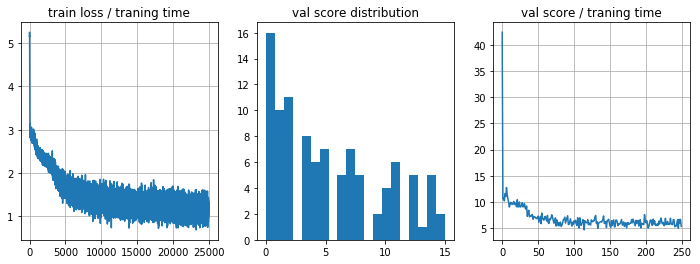

  0%|          | 0/407 [00:00<?, ?it/s]

llh=1.164, mean score=5.802
כל אנשי סמיילי -> anashi samili
קטגוריה:ערוץ 2 -> subbox in arrots
עבודה מהבית -> aboda mahavit
פראליה -> pralia
קפלר 42 -> capeller 42
קטגוריה:מתאסלמים -> matalamis
בושמי -> boshmi
לאונרדו -> launardo
שאמה -> shama
עכברה -> achbara


100%|██████████| 407/407 [00:38<00:00, 10.52it/s]

Supervised test score: 5.80671687673


In [50]:
from Attention_model import AttentionGRUTranslationModel
tf.reset_default_graph()
s = tf.InteractiveSession()

model = AttentionGRUTranslationModel('attention_bidir_gru', inp_voc, out_voc,
                              emb_size=32, hid_size=64, bidirectional=True, attention_fun='simple', init='random')
run_model(model)

Another variant of tanh :)

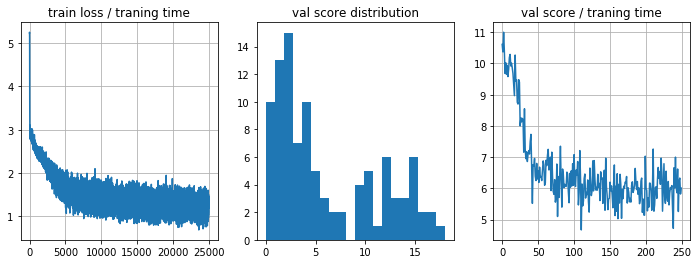

  0%|          | 0/407 [00:00<?, ?it/s]

llh=1.268, mean score=6.118
כל אנשי סמיילי -> shall insie sani
קטגוריה:ערוץ 2 -> 20101 count
עבודה מהבית -> aboda mahavith
פראליה -> pralia
קפלר 42 -> capeler 42
קטגוריה:מתאסלמים -> mathasselmim
בושמי -> boshmi
לאונרדו -> leonerdo
שאמה -> shama
עכברה -> achabra


100%|██████████| 407/407 [01:05<00:00,  6.25it/s]

Supervised test score: 5.83061789118


In [54]:
from Attention_model import AttentionGRUTranslationModel
tf.reset_default_graph()
s = tf.InteractiveSession()

model = AttentionGRUTranslationModel('attention_bidir_gru', inp_voc, out_voc,
                              emb_size=32, hid_size=64, bidirectional=True, attention_fun='tanh_hard', init='random')
run_model(model)

Final conclusion - Attention is all you need :) works well enough both with GRU forward and bidirectional and more or less good enough with different functions inside. It's hard to  get the same score with hard_mode.

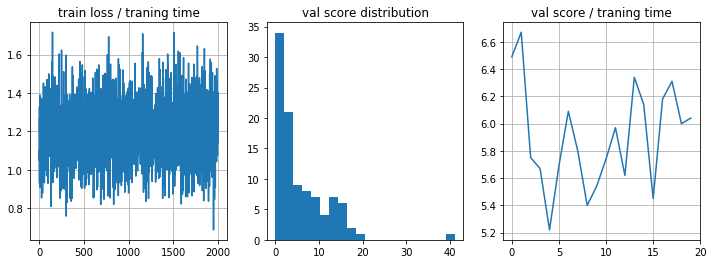

  0%|          | 0/407 [00:00<?, ?it/s]

llh=1.250, mean score=5.979
כל אנשי סמיילי -> came of anchie smili
קטגוריה:ערוץ 2 -> chall sconce
עבודה מהבית -> aboda mahabit
פראליה -> pralia
קפלר 42 -> capler 42
קטגוריה:מתאסלמים -> mathaslamim
בושמי -> boshmi
לאונרדו -> leonerdo
שאמה -> shama
עכברה -> achabra


100%|██████████| 407/407 [00:37<00:00, 10.84it/s]

Supervised test score: 6.01160467261


In [56]:
run_model(model, 2000)

`[your report/log here or anywhere you please]`